# Basic Usage

## Minimal example: Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import ezmc

Simulate some data from a regression model,

$$
y \sim Normal(\alpha + \beta x, \sigma^2);
$$

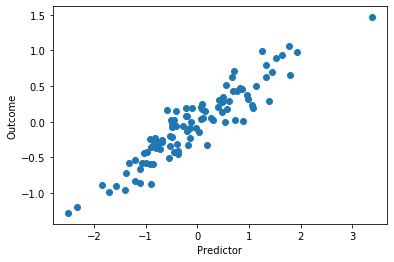

In [2]:
intercept = 0. ## α
slope = .5     ## β
noise = .2     ## σ2
n = 100
true_parameters = [intercept, slope, noise]

x = np.random.normal(0, 1, n)
y = np.random.normal( intercept + slope *x, noise, n)
plt.scatter(x, y)
plt.xlabel('Predictor')
plt.ylabel('Outcome')
plt.show()

In [13]:
ols = stats.linregress(x, y)
ols_estimates = [ols.intercept, ols.slope, ols.stderr * np.sqrt(n)]
print('Maximum likelihood parameters: intercept = %.2f, slope=%.2f, noise=%.2f' % tuple(ols_estimates))

Maximum likelihood parameters: intercept = -0.01, slope=0.49, noise=0.19


Set up a a function that takes parameters $[\alpha, \beta, \sigma^2]$ as inputs,
and returns the log posterior density for those parameters as it's output.
In this case, we can calculate this directly using the `scipy.stats.norm.logpdf()`. 

In [4]:
def get_prior_density(pars):
    ## Normal(0, 2) prior on all parameters.
    intercept, slope, noise = pars
    dens = (stats.norm.logpdf(loc=0, scale=2, x=intercept) + 
            stats.norm.logpdf(loc=0, scale=2, x=slope) + 
            stats.norm.logpdf(loc=0, scale=2, x=noise))
    return dens
    
def get_likelihood(pars, x, y):
    ## Ordinary linear regression
    intercept, slope, noise = pars
    ll = stats.norm.logpdf(loc = intercept + slope * x, scale=noise, x=y)
    return np.sum(ll)

def get_posterior_density(pars, x, y):
    ## Posterior log-lik = prior + posterior
    intercept, slope, noise = pars
    prior = get_prior_density(pars)
    lik = get_likelihood(pars, x, y)
    if noise <= 0:
        ## Noise can't be negative. 
        ## Return a very low value, but include prior 
        # density to guide sampler towards sensible values.
        return prior - 1e+10
    else:
        return prior + lik

def f(pars): ## A neat wrapper
    return get_posterior_density(pars, x, y)

def init(): ## Initial values for each chain.
    r = np.random.normal(0, 10, 3)
    while r[2] < 0:
        ## Don't start with negative noise terms.
        r = np.random.normal(0, 10, 3)
    return r

f(true_parameters) # Make sure it works with the true parameter values

20.047546900361937

To create a sampler, give it the log posterior density function,
the names of the parameters, the proposal standard deviation,
and a function that produces initial values.

In [5]:
sampler = ezmc.MetropolisSampler(func=f, par_names=['intercept', 'slope', 'noise'],
                                 proposal_sd=.05, 
                                 noisy=False,
                                 init_func=init)
sampler.sample_chains(1000) ## Draw some initial samples


Starting chain 1
#1000, #jumps = 800, Pars = -2.2191,-2.8507,6.4135, ll = -307.40
Starting chain 2
#1000, #jumps = 646, Pars = 0.0122,0.5060,0.1666, ll = 18.127
Starting chain 3
#1000, #jumps = 731, Pars = -13.4051,7.1978,12.5160, ll = -472.41
Starting chain 4
#1000, #jumps = 344, Pars = -0.0162,0.4963,0.1968, ll = 20.1736

Check if it's close to convergance.

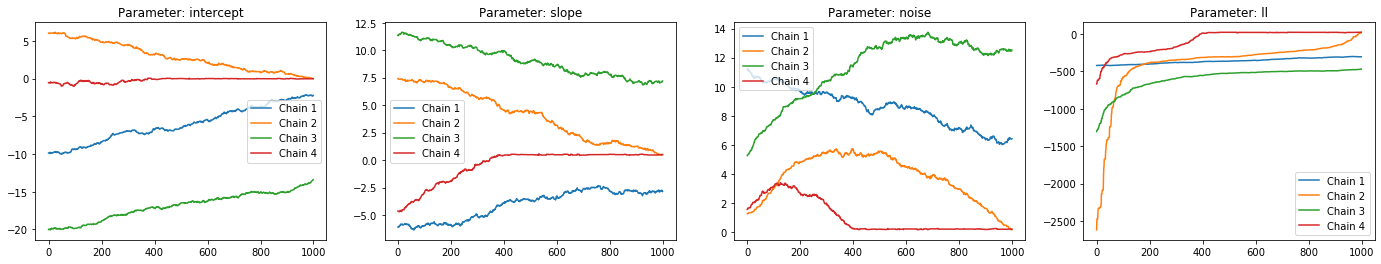

In [6]:
chains = sampler.get_chains()
ezmc.viz.traceplot(chains);  ## Colon prevents figure printing twice.

Nope. Draw more samples and check again.


Starting chain 1
#10000, #jumps = 1833, Pars = -0.0540,0.4697,0.2049, ll = 16.6976
Starting chain 2
#10000, #jumps = 1459, Pars = 0.0127,0.5071,0.1906, ll = 19.78
Starting chain 3
#10000, #jumps = 3014, Pars = -0.0034,0.4871,0.1958, ll = 20.36006
Starting chain 4
#10000, #jumps = 1040, Pars = 0.0096,0.4610,0.2020, ll = 18.60

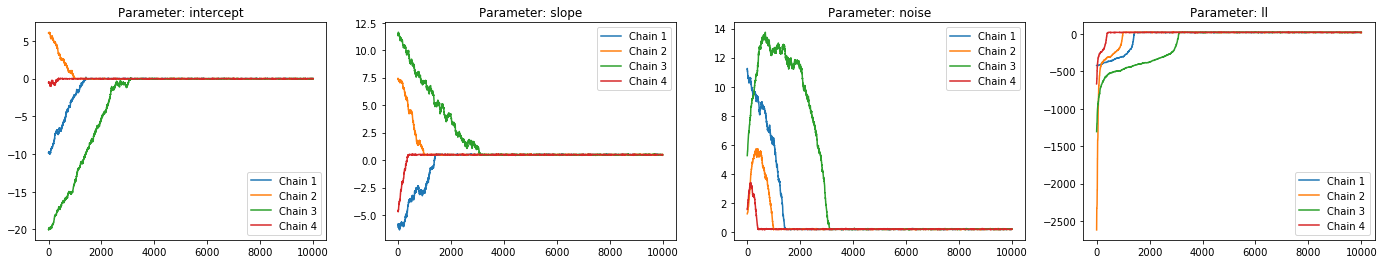

In [7]:
sampler.sample_chains(n=9000)
chains = sampler.get_chains()
ezmc.viz.traceplot(chains);

Better. Now extract samples after convergence, and thin them.

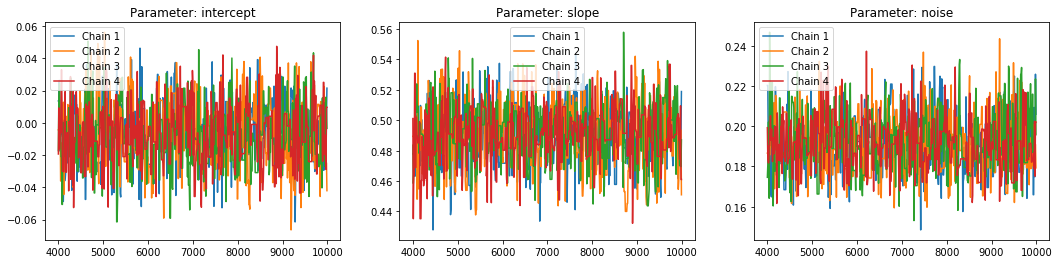

In [8]:
results = sampler.get_results(burn_in=4000, thin=10)
ezmc.viz.traceplot(results, pars=sampler.par_names);

Summarise and visualise the posterior samples.
Later, we'll see how to use tools like `Arviz` to produce more sophisticated visualisations.

In [9]:
res = ezmc.utils.summarise(results)
res.round(2)

,Estimate,SE,CI_low,CI_high,P(b > 0)
intercept,-0.01,0.02,-0.04,0.03,0.35
slope,0.49,0.02,0.45,0.53,1.00
noise,0.19,0.01,0.17,0.22,1.00


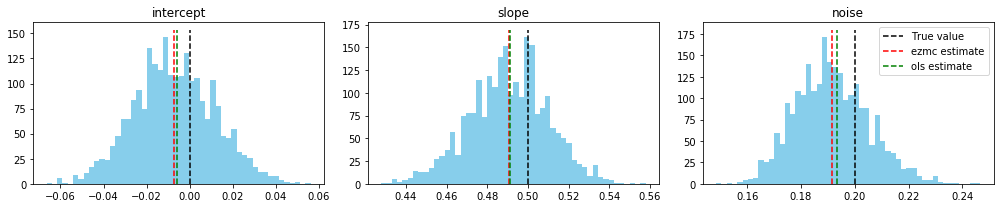

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for i, par in enumerate(sampler.par_names):
    ax = axes[i]
    ax.hist(results[par], bins=50, color='skyblue')
    ax.set_title(par)
    yl = ax.get_ylim()
    ax.vlines(true_parameters[i], linestyle='dashed', *yl, label='True value', color='k')
    ax.vlines(res.loc[par, 'Estimate'], linestyle='dashed', *yl, label='ezmc estimate', color='r')
    ax.vlines(ols_estimates[i], linestyle='dashed', *yl, label='ols estimate', color='g')
    plt.legend()
plt.tight_layout()
plt.show()